In [1]:
!pip install mamba-ssm
!pip install -e ../dynadojo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_c

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from dynadojo.systems.lorenz import LorenzSystem
from dynadojo.systems.lv import PreyPredatorSystem
from dynadojo.systems.lds import LDSystem
from dynadojo.systems.kuramoto import KuramotoSystem

from dynadojo.wrappers import SystemChecker, AlgorithmChecker
from dynadojo.utils.lds import plot
from dynadojo.utils.lv import plot as plot_lv

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

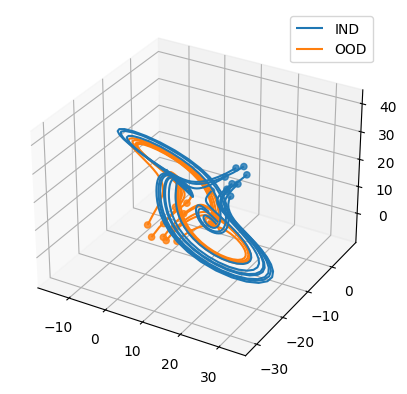

In [41]:
latent_dim = 3
embed_dim = latent_dim
n = 30
test_size = 10
timesteps = 100
system = SystemChecker(LorenzSystem(latent_dim, embed_dim, noise_scale=0, seed=1912,
                                    sigma=10, r=28, a_squared=1/2.0, b=8.0/3.0, t_range=(0, 1),))
# system = SystemChecker(LDSystem(latent_dim, embed_dim, noise_scale=0, seed=1912))
# system = SystemChecker(PreyPredatorSystem(latent_dim, embed_dim))
# system = SystemChecker(KuramotoSystem(embed_dim, embed_dim))
x0 = system.make_init_conds(n)
y0 = system.make_init_conds(n, in_dist=False)
x = system.make_data(x0, timesteps=timesteps)
y = system.make_data(y0, timesteps=timesteps, noisy=False)
plot([x, y], target_dim=min(latent_dim, 3), labels=["IND", "OOD"], max_lines=test_size)

In [5]:
import torch
import torch.nn as nn
import numpy as np
from math import sqrt
from einops import rearrange

class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return (V.contiguous(), A)
        else:
            return (V.contiguous(), None)

class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask

class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau=tau,
            delta=delta
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn


In [6]:
import concurrent.futures
import threading

import torch.nn as nn
import torch.nn.functional as F
import torch
from mamba_ssm import Mamba

class EncoderLayer(nn.Module):
    def __init__(self, attention, attention_r, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.attention_r = attention_r
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu
        self.man = Mamba(
            d_model=11,  # Model dimension d_model
            d_state=16,  # SSM state expansion factor
            d_conv=2,  # Local convolution width
            expand=1,  # Block expansion factor)
        )
        self.man2 = Mamba(
            d_model=11,  # Model dimension d_model
            d_state=16,  # SSM state expansion factor
            d_conv=2,  # Local convolution width
            expand=1,  # Block expansion factor)
        )
        self.a = AttentionLayer(
                        FullAttention(False, 2, attention_dropout=0.1,
                                      output_attention=True), 11,1)
    def forward(self, x, attn_mask=None, tau=None, delta=None):
        new_x = self.attention(x) + self.attention_r(x.flip(dims=[1])).flip(dims=[1])
        attn = 1

        x = x + new_x
        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn


class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for i, (attn_layer, conv_layer) in enumerate(zip(self.attn_layers, self.conv_layers)):
                delta = delta if i == 0 else None
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, tau=tau, delta=None)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns

In [7]:
import torch
import torch.nn as nn
import math

class DataEmbedding_inverted(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.1):
        super(DataEmbedding_inverted, self).__init__()
        self.value_embedding = nn.Linear(c_in, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        # x: [Batch Variate Time]
        x = self.value_embedding(x)
        return self.dropout(x)

In [8]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, start_from_epoch=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.best_weights = None
        self.start_from_epoch = start_from_epoch

    def early_stop(self, epoch, validation_loss, weights):
        if epoch < self.start_from_epoch:
            return False

        if weights is None:
            self.best_weights = weights
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.best_weights = weights
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [91]:
import torch
import torch.nn as nn
from mamba_ssm import Mamba
from dynadojo.abstractions import AbstractAlgorithm
from torch.utils.data import DataLoader, TensorDataset, random_split
import time
import logging

class SMamba(nn.Module, AbstractAlgorithm):

    def __init__(self,
                 embed_dim,
                 timesteps,
                 max_control_cost,
                 seed=None,
                 config: dict = {}):
        super(SMamba, self).__init__()
        AbstractAlgorithm.__init__(self, embed_dim, timesteps, max_control_cost, seed=seed)
        torch.nn.Module.__init__(self)

        if seed:
            torch.manual_seed(seed)

        self.seq_len = config.get('seq_len', int(0.1 * timesteps))
        self.pred_len = config.get('pred_len', timesteps - self.seq_len)
        self.d_model = config.get('d_model', 16)
        self.d_state = config.get('d_state', 16)
        self.d_ff = config.get('d_ff', 64)
        self.dropout = config.get('dropout', 0.1)
        self.activation = config.get('activation', 'gelu')
        self.e_layers = config.get('e_layers', 3)
        self.output_attention = config.get('output_attention', False)
        self.use_norm = config.get('use_norm', False)

        # Embedding
        self.enc_embedding = DataEmbedding_inverted(self.seq_len, self.d_model, dropout=self.dropout)
        self.class_strategy = config.get('class_strategy', 'projection')

        self.device = config.get('device', "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        logging.info(f"Using device: {self.device}")
        self.criterion = torch.nn.MSELoss()
        # Encoder-only architecture
        self.encoder = Encoder(
            [
                EncoderLayer(
                        Mamba(
                            d_model=self.d_model,  # Model dimension d_model
                            d_state=self.d_state,  # SSM state expansion factor
                            d_conv=2,  # Local convolution width
                            expand=1,  # Block expansion factor)
                        ),
                        Mamba(
                            d_model=self.d_model,  # Model dimension d_model
                            d_state=self.d_state,  # SSM state expansion factor
                            d_conv=2,  # Local convolution width
                            expand=1,  # Block expansion factor)
                        ),
                    self.d_model,
                    self.d_ff,
                    dropout=self.dropout,
                    activation=self.activation
                ) for l in range(self.e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(self.d_model)
        )
        self.projector = nn.Linear(self.d_model, self.pred_len, bias=True)

        # Send the model to the device
        self.to(self.device)


    def forecast(self, x_enc):
        if self.use_norm:
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc /= stdev

        _, _, N = x_enc.shape # B L N
        # B: batch_size;    E: d_model;
        # L: seq_len;       S: pred_len;
        # N: number of variate (tokens), can also includes covariates

        # Embedding
        # B L N -> B N E                (B L N -> B L E in the vanilla Transformer)
        enc_out = self.enc_embedding(x_enc) # covariates (e.g timestamp) can be also embedded as tokens

        # B N E -> B N E                (B L E -> B L E in the vanilla Transformer)
        # the dimensions of embedded time series has been inverted, and then processed by native attn, layernorm and ffn modules
        enc_out, attns = self.encoder(enc_out, attn_mask=None)
        # B N E -> B N S -> B S N
        dec_out = self.projector(enc_out).permute(0, 2, 1)[:, :, :N] # filter the covariates

        if self.use_norm:
            # De-Normalization from Non-stationary Transformer
            dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
            dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))

        return dec_out


    def forward(self, x_enc):
        dec_out = self.forecast(x_enc)
        return dec_out[:, -self.pred_len:, :]  # [B, L, D]


    def fit(self, x: np.ndarray, config: dict = {}):

        self.epochs = config.get('epochs', 5000)
        self.batch_size = config.get('batch_size', 32)
        self.lr = config.get('lr', 1e-2)
        self.validation_split = config.get('validation_split', 0.1)
        self.patience = config.get('patience', 15)
        self.min_delta = config.get('min_delta', 0.0)
        self.start_early_stop_from_epoch = config.get('start_early_stop_from_epoch', 1000)
        self.verbose = config.get('verbose', 0)

        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr) #, weight_decay=1e-2)

        if self.validation_split == 0 or self.patience == 0:
            if self.verbose > 0:
                print('Training on the full dataset, no validation, no early stopping')
            train = np.array(x)
            train_size = len(x)
            early_stopper = None
            val_losses = None
        else:
            if self.verbose > 0:
                print(f'Training on {1-self.validation_split} of the data, validating on the rest')
                print(f'Early stopping from epoch {self.start_early_stop_from_epoch} with patience {self.patience} and min_delta {self.min_delta}')
            validation_size = int(x.shape[0] * self.validation_split)
            train_size = len(x) - validation_size
            train, val = random_split(x, [len(x)-validation_size, validation_size])
            train = np.array(train)
            val = np.array(train)
            val_losses = []

            #Validation dataset
            x_val = []; y_val = []
            for j in range(val.shape[0]):
                for i in range(val.shape[1] - (self.seq_len+self.pred_len-1)):
                    x_val.append(val[j,i:i+self.seq_len,:])
                    y_val.append(val[j,i+self.seq_len:i+self.seq_len+self.pred_len,:])
            x_val = torch.tensor(np.array(x_val), dtype=torch.float32).to(self.device)
            y_val = torch.tensor(np.array(y_val), dtype=torch.float32).to(self.device)

            early_stopper = EarlyStopper(patience=self.patience, min_delta=self.min_delta, start_from_epoch=self.start_early_stop_from_epoch)

        if self.batch_size > train_size:
            self.batch_size = train_size

        x = []; y = []
        for j in range(train.shape[0]):
            for i in range(train.shape[1] - (self.seq_len+self.pred_len-1)):
                x.append(train[j,i:i+self.seq_len,:])
                y.append(train[j,i+self.seq_len:i+self.seq_len+self.pred_len,:])

        x = torch.tensor(np.array(x), dtype=torch.float32).to(self.device)
        y = torch.tensor(np.array(y), dtype=torch.float32).to(self.device)

        dataloader = DataLoader(TensorDataset(x, y), batch_size=self.batch_size, shuffle=True) #, num_workers=4)

        losses = []
        self.train()
        training_start_time = time.time()

        for epoch in range(self.epochs):
            self.train()
            epoch_loss = 0
            for input_seq, target_seq in dataloader:
                input_seq, target_seq = input_seq.to(self.device), target_seq.to(self.device)
                optimizer.zero_grad(set_to_none=True)
                y_hat = self.forward(input_seq)
                loss = self.criterion(y_hat, target_seq)
                epoch_loss += loss
                loss.backward()
                optimizer.step()

            losses.append(epoch_loss/len(dataloader))

            if early_stopper is None:
                if self.verbose > 0 and (epoch+1) % 10 == 0:
                    print(f'Epoch [{epoch+1}/{self.epochs}], Loss: {epoch_loss/len(dataloader):.4f}, took {time.time() - training_start_time:.2f}s')
                    training_start_time = time.time()
            else:
                self.eval()  # Set model to evaluation mode
                with torch.no_grad():  # Disable gradient calculation for validation
                    # Make predictions on validation set
                    val_outputs = self(x_val).detach()
                    val_loss = self.criterion(val_outputs, y_val).item()

                    if self.verbose > 0 and (epoch+1) % 10 == 0:
                        print(f'Epoch [{epoch+1}/{self.epochs}], Loss: {epoch_loss/len(dataloader):.4f}, Val Loss: {val_loss:.4f}, , took {time.time() - training_start_time:.2f}s')
                        training_start_time = time.time()

                    val_losses.append(val_loss)

                if early_stopper.early_stop(epoch, val_loss, self.state_dict()):
                    if self.verbose > 0:
                        print(f'Early stopping at epoch {epoch+1}')
                        print(f'Epoch [{epoch+1}/{self.epochs}], Loss: {epoch_loss/len(dataloader):.4f}, Val Loss: {val_loss:.4f}')
                    break
        if early_stopper is not None:
            self.load_state_dict(early_stopper.best_weights)
        return {
	            "train_loss": losses,
	            "val_loss": val_losses
                }

    def predict(self, x0: np.ndarray, timesteps: int, **kwargs) -> np.ndarray:
        x0seq=kwargs.get('init_seq', None)
        self.eval()
        with torch.no_grad():
            trajectory = x0.reshape(x0.shape[0], 1, x0.shape[1])
            if x0seq is not None:
                trajectory = x0seq
            next_input = torch.tensor(trajectory, dtype=torch.float32).to(self.device)

            # Iteratively predict future values
            for _ in range(self.seq_len, timesteps, self.pred_len):
                output = self.forward(next_input)
                if self.seq_len > self.pred_len:
                    next_input = torch.concatenate([next_input[:, self.pred_len:, :], output[:, -self.pred_len:, :]], axis=1)
                else:
                    next_input = output[:, -self.seq_len:, :]
                to_add = output.cpu().numpy()
                trajectory = np.concatenate([trajectory, to_add], axis=1)
        return trajectory[:, -timesteps:, :]


In [105]:
smamba_config = {
    "seq_len": 10,
    "pred_len": 90,
    "d_model": 16,
    "d_state": 16,
    "d_ff": 64,
    "dropout": 0.1,
    "activation": "gelu",
    "e_layers": 3,
    "output_attention": False,
    "use_norm": False,
    "epochs": 5000,
    "batch_size": 50,
    "lr": 1e-2,
    "validation_split": 0.1,
    "patience": 15,
    "min_delta": 0,
    "start_early_stop_from_epoch": 800,
    "verbose": 1
}

In [106]:
model = AlgorithmChecker(SMamba(embed_dim, timesteps, max_control_cost=0, seed=42, config=smamba_config))

In [107]:
model.fit(x, config=smamba_config)

Training on 0.9 of the data, validating on the rest
Early stopping from epoch 800 with patience 15 and min_delta 0
Epoch [10/5000], Loss: 181.8645, Val Loss: 177.9621, , took 0.24s
Epoch [20/5000], Loss: 146.7166, Val Loss: 142.3708, , took 0.24s
Epoch [30/5000], Loss: 112.1114, Val Loss: 108.5742, , took 0.24s
Epoch [40/5000], Loss: 84.3817, Val Loss: 81.7226, , took 0.23s
Epoch [50/5000], Loss: 62.8705, Val Loss: 60.7930, , took 0.23s
Epoch [60/5000], Loss: 47.3599, Val Loss: 46.0003, , took 0.23s
Epoch [70/5000], Loss: 36.8786, Val Loss: 34.7692, , took 0.25s
Epoch [80/5000], Loss: 30.6274, Val Loss: 28.3894, , took 0.24s
Epoch [90/5000], Loss: 25.1997, Val Loss: 23.2517, , took 0.25s
Epoch [100/5000], Loss: 22.2460, Val Loss: 20.0170, , took 0.25s
Epoch [110/5000], Loss: 18.0082, Val Loss: 16.1143, , took 0.25s
Epoch [120/5000], Loss: 15.4083, Val Loss: 15.2178, , took 0.34s
Epoch [130/5000], Loss: 13.6427, Val Loss: 11.7801, , took 0.32s
Epoch [140/5000], Loss: 11.0180, Val Loss: 

x_err=1.8431584638669112


(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

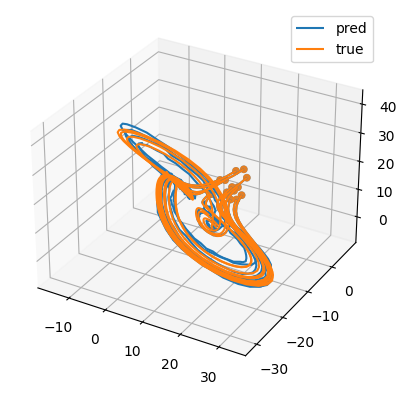

In [108]:
x_pred = model.predict(x0, timesteps, init_seq=x[:,:10,:])
x_err = system.calc_error(x, x_pred)
print(f"{x_err=}")
plot([x_pred, x], target_dim=min(3, latent_dim), labels=["pred", "true"], max_lines=15)

(<Figure size 1600x400 with 3 Axes>, <Axes3D: >)

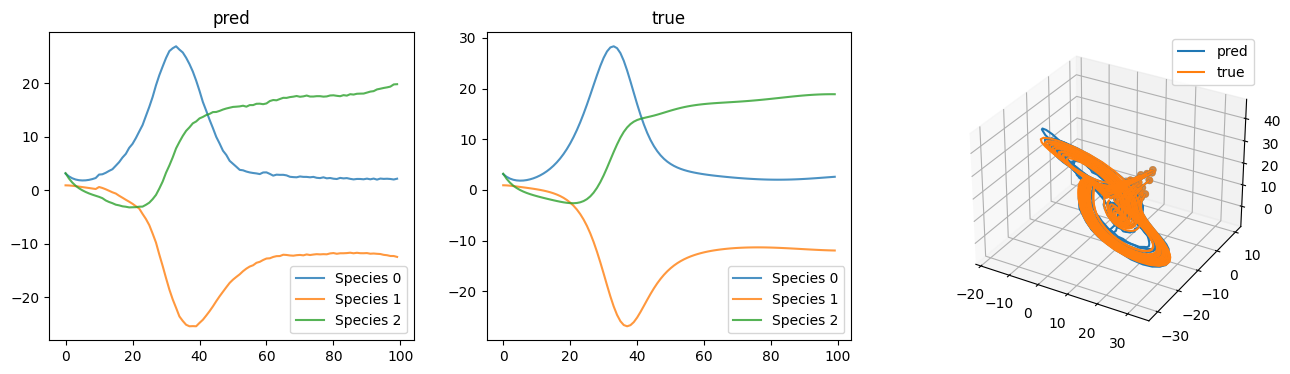

In [109]:
plot_lv([x_pred,x],target_dim=3, labels=["pred", "true"], max_lines=50)

In [110]:
!pip install ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 11.7 MB/s eta 0:00:00


In [116]:
from ray import tune

smamba_small_search_space = {
    "seq_len": int(0.1*timesteps),
    "pred_len": timesteps - int(0.1*timesteps),
    "d_model": 16,
    "d_state": 16,
    "d_ff": 64,
    "dropout": 0.1,
    "activation": "gelu",
    "e_layers": 3,
    "output_attention": tune.choice([True, False]),
    "use_norm": tune.choice([True, False]),
    "epochs": 10000,
    "batch_size": 50,
    "lr": tune.loguniform(1e-2, 1e-4),
    "validation_split": 0.1,
    "patience": 15,
    "min_delta": 0.0,
    "start_early_stop_from_epoch": tune.choice([500, 1000, 1500]),
    "verbose": 0
}

smamba_large_search_space = {
    "seq_len": int(0.1*timesteps),
    "pred_len": timesteps - int(0.1*timesteps),
    "d_model": tune.choice([16, 32, 64]),
    "d_state": tune.choice([16, 32, 64]),
    "d_ff": tune.choice([32, 64, 128, 256]),
    "dropout": tune.choice([0.1, 0.2, 0.3]),
    "activation": "gelu",
    "e_layers": tune.choice([2, 3, 4]),
    "output_attention": tune.choice([True, False]),
    "use_norm": tune.choice([True, False]),
    "epochs": tune.choice([5000,10000]),
    "batch_size": tune.choice([32, 64, 128]),
    "lr": tune.loguniform(1e-2, 1e-4),
    "validation_split": 0.1,
    "patience": tune.choice([10, 15, 20]),
    "min_delta": tune.choice([0.0, 0.1, 0.2]),
    "start_early_stop_from_epoch": tune.choice([500, 1000, 1500]),
    "verbose": 0
}